In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, InceptionResNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers, preprocessing, optimizers

import optuna
# from optuna.integration import KerasPruner

In [59]:
labels = ['NORMAL', 'PNEUMONIA']
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []
image_size = 128

for i in labels:
    folderPath = os.path.join('../input/chest-xray-pneumonia/chest_xray/train', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    folderPath = os.path.join('../input/chest-xray-pneumonia/chest_xray/val', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_val.append(img)
        y_val.append(i)

for i in labels:
    folderPath = os.path.join('../input/chest-xray-pneumonia/chest_xray/test', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=14)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


100%|██████████| 390/390 [00:02<00:00, 135.32it/s]


(5216, 128, 128, 3)
(16, 128, 128, 3)
(624, 128, 128, 3)


In [60]:
print(dict(zip(*np.unique(y_train, return_counts=True))))
print(dict(zip(*np.unique(y_val, return_counts=True))))
print(dict(zip(*np.unique(y_test, return_counts=True))))


{'NORMAL': 1341, 'PNEUMONIA': 3875}
{'NORMAL': 8, 'PNEUMONIA': 8}
{'NORMAL': 234, 'PNEUMONIA': 390}


In [61]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

x_train, y_train = shuffle(X_train,y_train, random_state=11)
x_train = np.array(x_train) / 255.
x_val = np.array(X_val) / 255.
x_test = np.array(X_test) / 255.


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [62]:
# plt.figure (figsize = (8,4))
# plt.imshow (x_train [0][0] , cmap = 'gray')
# plt.title (labels [train [0][1]])

# plt.figure (figsize = (8,4))
# plt.imshow (x_train [-1][0], cmap = 'gray')
# #plt.axis ('off')
# plt.title (labels [train [-1][1]])

In [70]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 4)
    layers_list = []
    layers_list.append(layers.Input((image_size, image_size, 3)))
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    for i in range(n_layers):
        filter = trial.suggest_int("filter_{}".format(i), 5, 8)
        layers_list.append(layers.Conv2D(2**filter, (3, 3), activation="relu", padding="same"))
        layers_list.append(layers.BatchNormalization())
        layers_list.append(layers.Conv2D(2**filter, (3, 3), activation="relu", padding="same"))
        layers_list.append(layers.BatchNormalization())
        layers_list.append(layers.MaxPooling2D(2, 2))
        layers_list.append(layers.Dropout(dropout))
        
    layers_list.append(layers.Flatten())
    layers_list.append(layers.Dense(128, activation="linear"))
    layers_list.append(layers.Dropout(0.5))
    layers_list.append(layers.Dense(2, activation="sigmoid"))

    return keras.Sequential(layers_list)

def objective(trial):
    # Создание модели
    model = define_model(trial)
    
    # Компиляция модели
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    
    # pruning_callback = KerasPruningCallback(trial, 'val_accuracy')
    
    history = model.fit(x_train[:400], y_train[:400],
                        validation_data=(x_val, y_val),
                        shuffle=True,
                        epochs=5,
                        batch_size=40,
                        # validation_split=0.1,
                        # callbacks=[pruning_callback]
                       )

    # Возвращаем значение метрики для оптимизации (например, валидируемую точность)
    return max(history.history['val_auc'])


In [71]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=7000, show_progress_bar=True)

[I 2024-10-10 01:56:17,435] A new study created in memory with name: no-name-63624698-0f3b-4b41-9f43-1342a64e13f9


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - auc: 0.7168 - loss: 72.2169 - val_auc: 0.6992 - val_loss: 4.7537
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - auc: 0.8851 - loss: 29.0065 - val_auc: 0.5312 - val_loss: 37.0038
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - auc: 0.9009 - loss: 28.3822 - val_auc: 0.5312 - val_loss: 45.2591
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - auc: 0.9537 - loss: 8.8451 - val_auc: 0.7188 - val_loss: 10.4289
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - auc: 0.9693 - loss: 5.1015 - val_auc: 0.8223 - val_loss: 3.7095
[I 2024-10-10 02:00:58,382] Trial 0 finished with value: 0.822265625 and parameters: {'n_layers': 1, 'dropout': 0.4081882552120894, 'filter_0': 6}. Best is trial 0 with value: 0.822265625.
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 106s 10s/step - auc: 0.6400 - loss: 69.1611 - val_auc: 0.5000 - val_loss: 23.1640
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - auc: 0.8447 - loss: 22.2254 - val_auc: 0.5156 - val_loss: 12

In [72]:
best_model = define_model(study.best_trial)
# best_model = define_model(frozen_trial)

best_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = best_model.fit(x_train, y_train,
                validation_data=(x_test, y_test),
                epochs=10,
                batch_size=32,
                shuffle=True)

# Сохранение лучшей модели в файл
best_model.save("pneumonia_model.h5")

print("Best trial parameters: ", study.best_trial.params)
print("Best trial accuracy: ", study.best_trial.value)
# print("Best trial parameters: ", frozen_trial)
# print("Best trial accuracy: ", frozen_trial)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 679s 4s/step - accuracy: 0.8803 - loss: 48.9955 - val_accuracy: 0.7340 - val_loss: 15.7024
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 658s 4s/step - accuracy: 0.9575 - loss: 12.4015 - val_accuracy: 0.8590 - val_loss: 14.1278
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 660s 4s/step - accuracy: 0.9621 - loss: 11.8394 - val_accuracy: 0.8237 - val_loss: 35.4242
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 678s 4s/step - accuracy: 0.9773 - loss: 3.8146 - val_accuracy: 0.7532 - val_loss: 120.6392
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 677s 4s/step - accuracy: 0.9796 - loss: 3.0525 - val_accuracy: 0.7468 - val_loss: 105.1336
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.9822 - loss: 1.8815 - val_accuracy: 0.7196 - val_loss: 102.0436
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 684s 4s/step - accuracy: 0.9902 - loss: 1.0569 - val_accuracy: 0.7308 - val_loss: 86.1236
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.9926 - loss: 0.65

In [73]:
best_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,781,640 (384.45 MB)

 Trainable params: 33,593,794 (128.15 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 67,187,590 (256.30 MB)

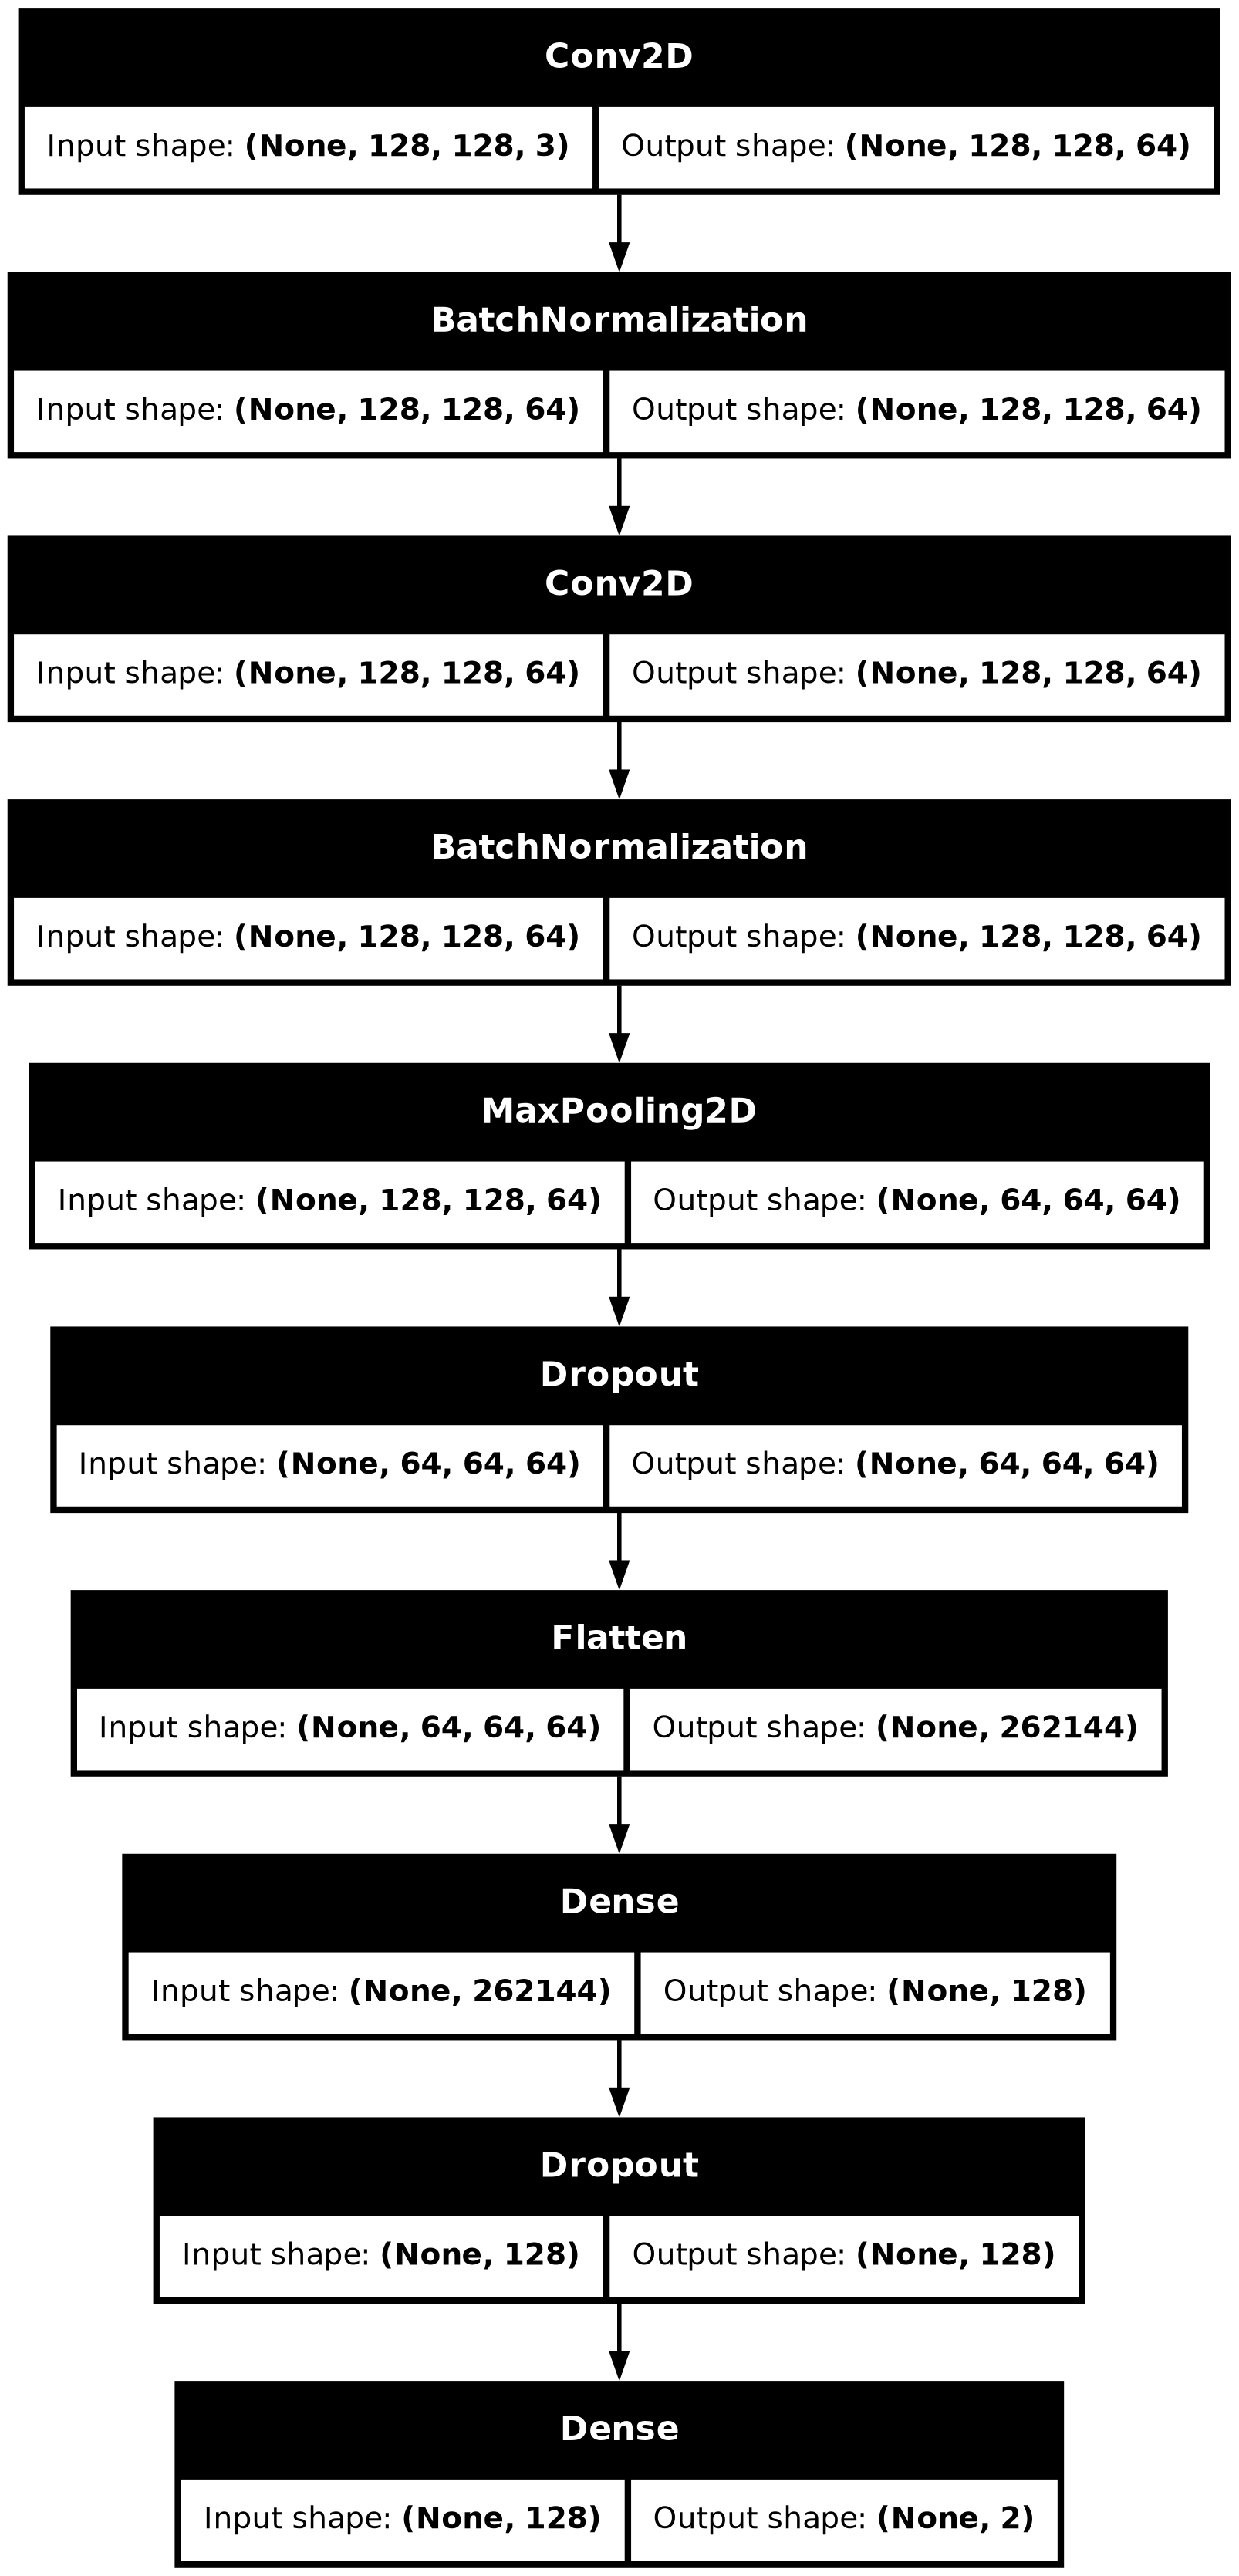

In [74]:
from tensorflow.keras.utils import plot_model

plot_model(best_model, to_file='pneumonia_model.png', show_shapes=True)

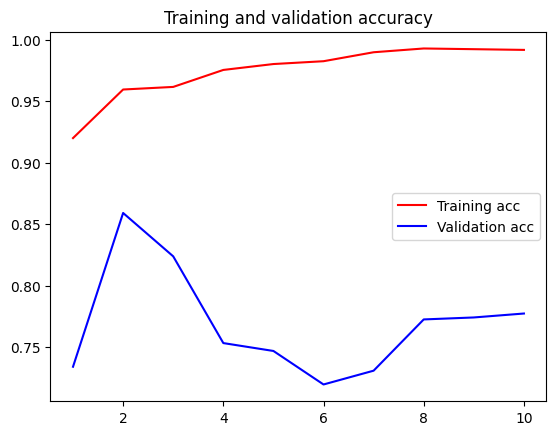

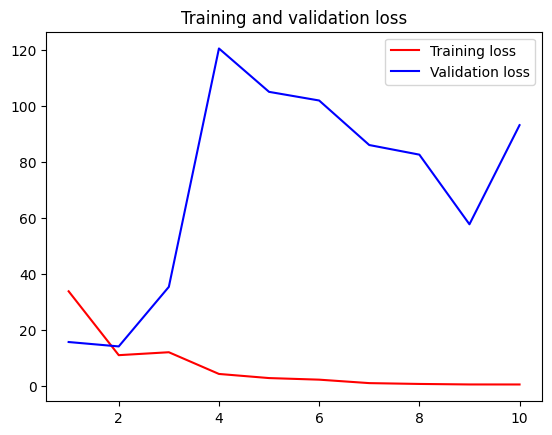

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [76]:
pred = best_model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

print(classification_report(y_test_new,pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Accuracy on testing dataset: 80.93%
              precision    recall  f1-score   support

           0       0.96      0.51      0.67       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.84      0.81      0.79       624

